In [1]:
# Copyright 2025 Andrew Lehr
# The MIT License

## Figure 5
#### Evoked sequences

### Imports

In [3]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from brian2 import *
import time
from datetime import datetime
from scipy import signal
from scipy import io

In [4]:
from spreizer_net import SpreizerNet
import params

### Parameters

In [5]:
data_dir = '/home/andrew/Documents/projects/submanifolds/subspace_projections_with_selective_inhibition/spiking_network/evoked_sequence_simulations/saves/spike_monitors/'
figs_dir = '/home/andrew/Documents/projects/submanifolds/subspace_projections_with_selective_inhibition/spiking_network/evoked_sequence_simulations/figures/'
simtime = 400
nPopE = params.network_dimensions['n_pop_e']
nPopI = params.network_dimensions['n_pop_i']
seed_value = 0

In [6]:
colors = ['#586ba4', '#f68e5f', '#f5dd90', '#324376', '#f76c5e', 
          '#067d7a', '#77c1b3', '#f3c759', '#ed7364', '#b63653',
          '#6d2a2a', '#361a1a', '#191414', '#465865', '#928876',
          '#fc9234', '#fd6626', '#44867d', '#177070', '#404a50']

### Initialize and store network

In [7]:
height = 20
width = 20
top = 80
left = 20
spike_idcs = []
for row in range(height):
    for col in range(width):
        spike_idcs.append(120 * (row + top) + left + col)

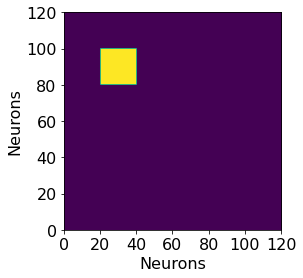

In [8]:
filename = 'input_location'
input_raster = np.zeros(nPopE)
input_raster[spike_idcs] = 1
plt.figure(figsize=(4,4))
plt.imshow(input_raster.reshape((120,120)), origin='lower', extent=(0, np.sqrt(nPopE), 0, np.sqrt(nPopE)))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Neurons', fontsize=16)
plt.ylabel('Neurons', fontsize=16)
plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

In [9]:
sn = SpreizerNet()  
sn.set_seed()  
sn.populate()  
sn.connect()  
sn.connect_external_input(spike_idcs, pulse_time=0*ms, mean_stim=1.1, sigma_stim=0.)
sn.set_initial_potentials()  
sn.connect_spike_monitors() 
sn.store_network() 

Je_orig = sn.synapses['ee'].namespace['Je']

In [10]:
from collections import defaultdict

np.random.seed(0)

#p_offs = np.array([0, 0.4, 0.8]).round(2) #np.array([0,0.1,0.4,0.7,0.8]).round(2)
p_offs = np.array([0,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).round(2) #np.arange(0,0.95,0.02).round(2)
n_p_offs = len(p_offs)
n_subspaces = 5
inh_input = 12500 * pA
neuron_list_e = np.arange(0,nPopE)
neuron_list_i = np.arange(0,nPopI)
subsets_e = defaultdict(dict)
subsets_i = defaultdict(dict)
on_offs_e = defaultdict(dict)
on_offs_i = defaultdict(dict)

for p_off_i, p_off in enumerate(p_offs):
    n_off_e = int(p_off*nPopE)
    n_off_i = int(p_off*nPopI)

    subsets_i[p_off] = np.random.choice(neuron_list_i, n_off_i, replace=False)
    on_offs_i[p_off] = np.zeros(nPopI)
    on_offs_i[p_off][subsets_i[p_off]] = inh_input 
    
    for subspace in range(n_subspaces):
        
        subsets_e[p_off, subspace] = np.random.choice(neuron_list_e, n_off_e, replace=False)
        on_offs_e[p_off, subspace] = np.zeros(nPopE)
        on_offs_e[p_off, subspace][subsets_e[p_off, subspace]] = inh_input

In [11]:
angles = np.zeros((len(p_offs), int(n_subspaces*(n_subspaces-1)/2)))
for p_off_i, p_off in enumerate(p_offs):
    i = 0
    for subspace_i in range(n_subspaces):
        for subspace_j in range(subspace_i+1, n_subspaces):

            pi = (on_offs_e[p_off, subspace_i] == 0).astype(int)
            pj = (on_offs_e[p_off, subspace_j] == 0).astype(int)
            
            cos_theta = np.dot(pi,pj) / (np.linalg.norm(pi) * np.linalg.norm(pj))
            angles[p_off_i, i] = np.arccos(np.clip(cos_theta,-1,1))*180/np.pi
            i = i + 1

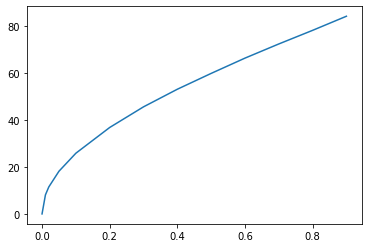

In [12]:
plt.plot(p_offs, angles.mean(axis=1))

### Multiple subsets

In [13]:
np.random.seed(seed_value)
n_trials = 5  #10

In [13]:
for p_off_i, p_off in enumerate(p_offs):
    for subspace in range(n_subspaces):

        on_off_e = on_offs_e[p_off, subspace]
        on_off_i = on_offs_i[p_off]
        
        for trial in range(n_trials):
            sn.restore_network()
            #sn.synapses['ee'].namespace['Je'] = Je_orig / (1 - p_off)
            seed(seed_value + trial)
            np.random.seed(seed_value + trial)
            sn.network.set_states({'e_neurons': {'clust_inh': on_off_e}})
            sn.network.set_states({'i_neurons': {'clust_inh': on_off_i}})
            sn.run_sim(simulation_time=simtime*ms)  
            sn.save_monitors('stimulation_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial))
            print ('pinh:' + str(p_off) + ', subspace:' + str(subspace) + ', trial:' + str(trial), end="\r")

Starting simulation at t=0. s for a duration of 0.4 s
194.1 ms (48%) simulated in 2s, estimated 2s remaining.
0.3729 s (93%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
186.1 ms (46%) simulated in 2s, estimated 2s remaining.
0.3931 s (98%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
198.1 ms (49%) simulated in 2s, estimated 2s remaining.
0.4 s (100%) simulated in 3s


Starting simulation at t=0. s for a duration of 0.4 s
175. ms (43%) simulated in 2s, estimated 3s remaining.
0.3548 s (88%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
196.1 ms (49%) simulated in 2s, estimated 2s remaining.
0.3996 s (99%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
188.9 ms (47%) simulated in 2s, estimated 2s remaining.
0.3784 s (94%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
165.4 ms (41%) simulated in 2s, estimated 3s remaining.
314.5 ms (78%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 5s


Starting simulation at t=0. s for a duration of 0.4 s
141.4 ms (35%) simulated in 2s, estimated 4s remaining.
280.6 ms (70%) simulated in 4s, estimated 2s remaining.
0.4 s (100%) simulated in 5s


Starting simulation at t=0. s for a duration of 0.4 s
147.9 ms (36%) simulated in 2s, estimated 3s remaining.
308. ms (76%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 5s


Starting simulation at t=0. s for a duration of 0.4 s
152.2 ms (38%) simulated in 2s, estimated 3s remaining.
0.3396 s (84%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
186.3 ms (46%) simulated in 2s, estimated 2s remaining.
0.3664 s (91%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
178.7 ms (44%) simulated in 2s, estimated 2s remaining.
0.3677 s (91%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
187.5 ms (46%) simulated in 2s, estimated 2s remaining.
0.3584 s (89%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
182.9 ms (45%) simulated in 2s, estimated 2s remaining.
0.3492 s (87%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
173.8 ms (43%) simulated in 2s, estimated 3s remaining.
0.3601 s (90%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
188.7 ms (47%) simulated in 2s, estimated 2s remaining.
0.3909 s (97%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
188.2 ms (47%) simulated in 2s, estimated 2s remaining.
0.3883 s (97%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
181.3 ms (45%) simulated in 2s, estimated 2s remaining.
0.3458 s (86%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
138.7 ms (34%) simulated in 2s, estimated 4s remaining.
315.5 ms (78%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
172.3 ms (43%) simulated in 2s, estimated 3s remaining.
0.3411 s (85%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
167.3 ms (41%) simulated in 2s, estimated 3s remaining.
0.3351 s (83%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
162. ms (40%) simulated in 2s, estimated 3s remaining.
0.347 s (86%) simulated in 4s, estimated 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
180.7 ms (45%) simulated in 2s, estimated 2s remaining.
0.3665 s (91%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
187.5 ms (46%) simulated in 2s, estimated 2s remaining.
0.3864 s (96%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


Starting simulation at t=0. s for a duration of 0.4 s
179.8 ms (44%) simulated in 2s, estimated 2s remaining.
0.3714 s (92%) simulated in 4s, estimated < 1s remaining.
0.4 s (100%) simulated in 4s


DimensionMismatchError: Incorrect unit for setting variable clust_inh (units are A and 1).

### Build spike rasters

In [14]:
# first we build the spike raster, defining a window inside which spikes are summed
window = 10
n_bins = int(simtime/window)

In [15]:
spk_raster = np.zeros((n_p_offs, n_subspaces, n_trials, nPopE, n_bins))
for p_off_i, p_off in enumerate(p_offs):
    for subspace in range(n_subspaces):
        for trial in range(n_trials):
            gs = np.load(data_dir + 'stimulation_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial) + '_e_i.npy')
            ts = np.load(data_dir + 'stimulation_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial) + '_e_t.npy')
            for j in range(n_bins): 
                mask = (ts>(j*window/1000)) & (ts<((j+1)*window/1000))
                spks = gs[mask]  
                spk_raster[p_off_i, subspace, trial, :, j] = np.bincount(spks, minlength=nPopE)

#### Plot example

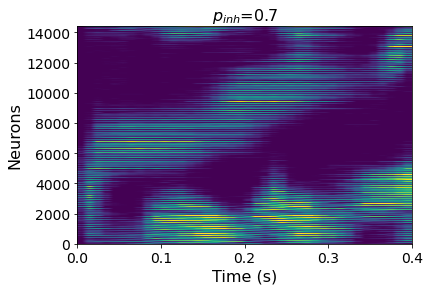

In [16]:
ex = 10
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.imshow(spk_raster[ex,2,0,:,:], aspect='auto', vmax=1, extent=(0, n_bins, 0, nPopE))
ax.set_title('$p_{inh}$=' + str(p_offs[ex]), fontsize=16)
xticks = np.arange(0,41,10)
ax.set_xticks(xticks)
ax.set_xticklabels(np.round(xticks/100, 1), fontsize=14)
yticks = np.arange(0,14400,2000)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=14)
ax.set_xlabel('Time (s)', fontsize=16)
ax.set_ylabel('Neurons', fontsize=16)
plt.show()

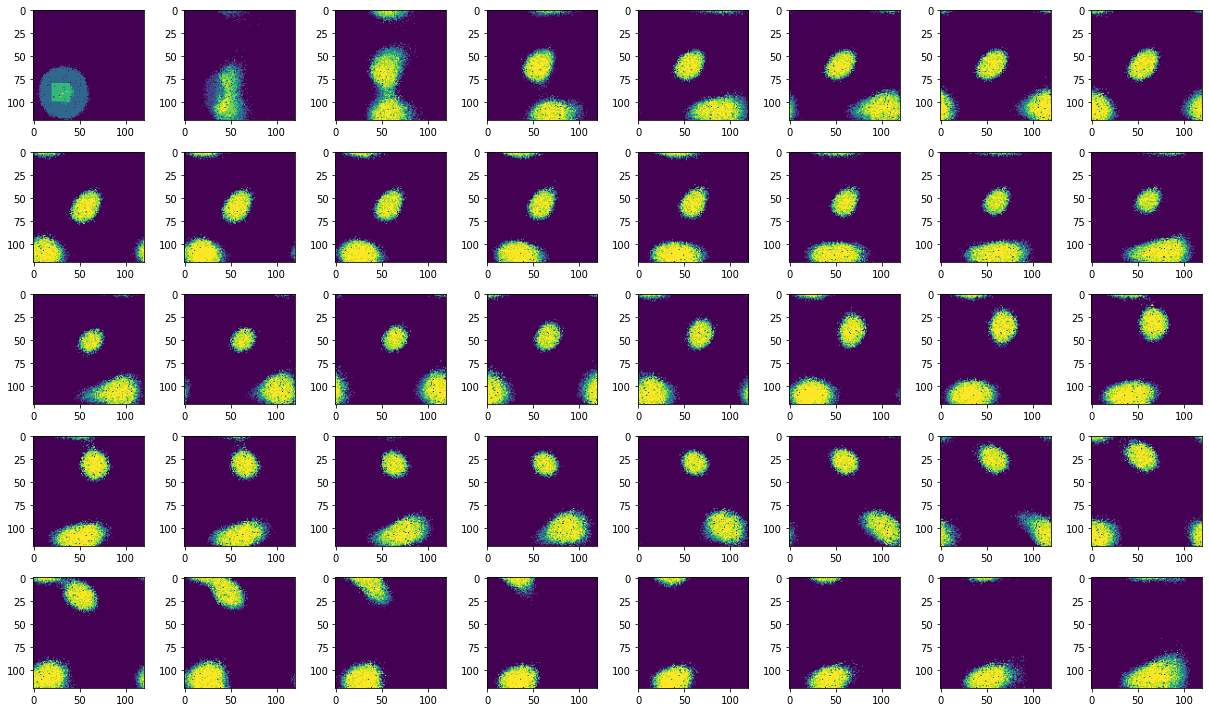

In [17]:
nrows = 5
ncols = 8
fig = plt.figure(figsize=(17,10))    
for i in range(1,nrows*ncols+1):
    ax = fig.add_subplot(nrows, ncols, i)
    ax.imshow(spk_raster[2,0,1,:,i-1].reshape(120,120))
fig.tight_layout()

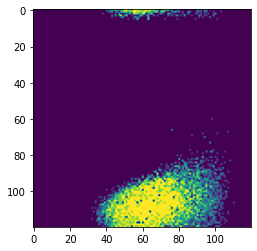

In [18]:
from matplotlib import animation

fig, ax1 = plt.subplots(1,1)
frames = [] # store generated images
for i in range(n_bins):
    img1 = ax1.imshow(spk_raster[2,1,0,:,i].reshape(120,120), animated=True)
    frames.append([img1])

ani = animation.ArtistAnimation(fig, frames, interval=150, blit=True,
                                repeat_delay=1000)
ani.save('movies/test.mp4')

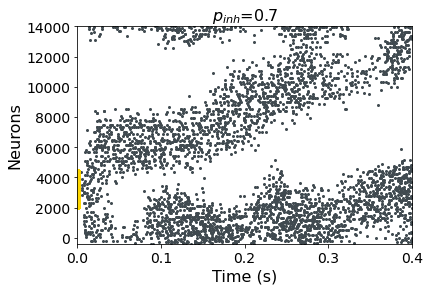

In [21]:
filename = 'spike_raster'
p_off = 0.7
subspace = 2
trial = 0
fig, ax = plt.subplots(1,1, figsize=(6,4))
gs = np.load(data_dir + 'stimulation_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial) + '_e_i.npy')
ts = np.load(data_dir + 'stimulation_sim_' + str(simtime) + 'ms_pinh_' + str(p_off) + '_subspace_' + str(subspace) + '_trial_' + str(trial) + '_e_t.npy')
plt.scatter(ts[np.arange(0,len(ts),25)], gs[np.arange(0,len(ts),25)], s=4, color=colors[-1])
plt.gca().invert_yaxis()
ax.set_title('$p_{inh}$=' + str(p_offs[ex]), fontsize=16)
ax.set_xlim(0,0.4)
ax.set_ylim(14400,0)
xticks = np.arange(0,0.41,0.1).round(1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=14)
yticks = np.arange(0,14400,2000)
ax.set_yticks(yticks)
ax.set_yticklabels(yticks[::-1], fontsize=14)
ax.set_xlabel('Time (s)', fontsize=16)
ax.set_ylabel('Neurons', fontsize=16)

plt.scatter(np.zeros(len(spike_idcs)), spike_idcs, color='gold')
plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

### Perlin

In [24]:
np.max(sn.neuron_groups['e'].x_shift[:])

0.025

In [25]:
np.max(sn.neuron_groups['e'].y_shift[:])

0.024999460051421882

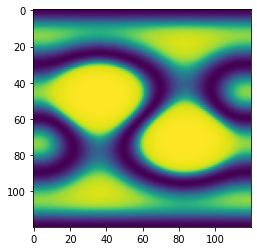

In [26]:
plt.imshow(sn.neuron_groups['e'].x_shift[:].reshape(120,120))

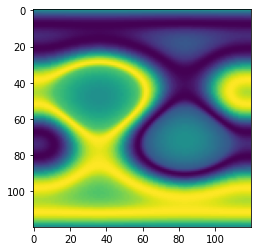

In [27]:
plt.imshow(sn.neuron_groups['e'].y_shift[:].reshape(120,120))

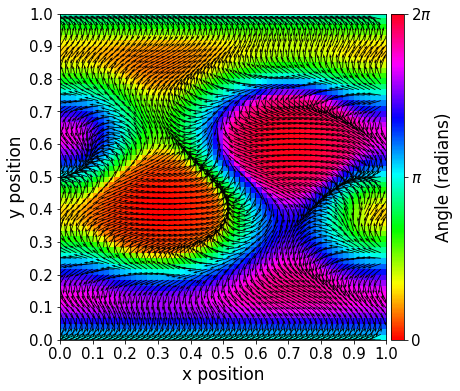

In [28]:
from perlin import generate_perlin

filename='perlin_landscape'
#net = Network()
landscape = generate_perlin(120, 2, seed_value=0)
U = np.cos(landscape)
V = np.sin(landscape)

ticks = np.round(np.arange(0,1.1,.1),1)

s = 2
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(landscape[::s, ::s], cmap='hsv', origin='lower', extent=(0, 60, 0, 60))
ax.set_xticks(np.arange(0,132,12)/s, np.round(np.arange(0,1.1,.1),1), fontsize=15)
ax.set_yticks(np.arange(0,132,12)/s, np.round(np.arange(0,1.1,.1),1), fontsize=15)
ax.set_xlabel('x position', fontsize=17)
ax.set_ylabel('y position', fontsize=17)
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.03,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax, ticks=[0, np.pi, 2*np.pi])
cbar.ax.set_yticklabels(['0', '$\pi$', '$2 \pi$'], fontsize=15)  
cbar.ax.set_ylabel('Angle (radians)', fontsize=17)

ax.quiver(U[::s, ::s], V[::s, ::s],scale=5,linewidth=0.4, scale_units='inches') #, label='Winds')

plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

### Plot activity across time

In [29]:
window

10

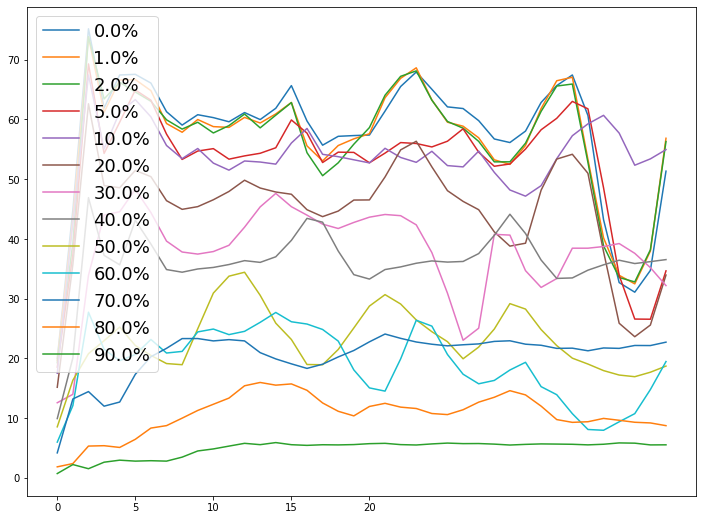

In [30]:
plt.figure(figsize=(12,9))
for i, p in enumerate(p_offs):
        plt.plot(np.mean(spk_raster[i,0,0,:,:], axis=0)*1000/window, label=str(100*p)+'%')

plt.xticks(np.arange(0,25,5))
plt.legend(fontsize=18)
plt.show()

## PCA results

In [31]:
n_components = 12
pca_dict = {}
exp_var = np.zeros((n_p_offs, n_subspaces, n_trials, n_components))
for p_off_i, p_off in enumerate(p_offs):
    for subspace in range(n_subspaces):
        for trial in range(n_trials):
            # note that we transpose the spike raster for the scaling and PCA, requires (n_samples, n_features)
            spk_raster_centered = StandardScaler().fit_transform(spk_raster[p_off_i, subspace, trial, :, :].T)
            pca_dict[p_off_i, subspace, trial] = decomposition.PCA(n_components=n_components)
            pca_dict[p_off_i, subspace, trial].fit_transform(spk_raster_centered)

            # cumulative variance
            exp_var[p_off_i, subspace, trial,:] = pca_dict[p_off_i, subspace, trial].explained_variance_ratio_.cumsum()

#### Explained variance

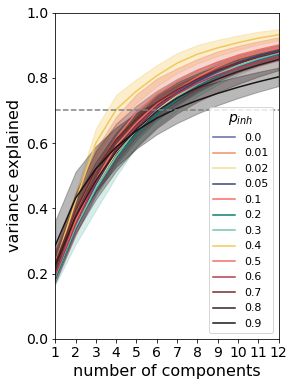

In [32]:
filename = 'var_exp'
plt.figure(figsize=(4,6))
for p_off_i, p_off in enumerate(p_offs):
    plt.plot(np.arange(1,13), exp_var[p_off_i, :, :, :].mean(axis=(0,1)), color=colors[p_off_i], label=p_off)
    plt.fill_between(np.arange(1,13),
                     exp_var[p_off_i, :, :, :].mean(axis=(0,1)) - exp_var[p_off_i, :, :, :].std(axis=(0,1)),
                     exp_var[p_off_i, :, :, :].mean(axis=(0,1)) + exp_var[p_off_i, :, :, :].std(axis=(0,1)), 
                     color=colors[p_off_i], alpha=0.3)
        
plt.xlim(1,12)
plt.ylim(0,1)
plt.xticks(np.arange(1,13), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('number of components', fontsize=16)
plt.ylabel('variance explained', fontsize=16)
plt.axhline(0.7, color='grey', linestyle='--')
legend = plt.legend(fontsize=11, title='$p_{inh}$')
legend.get_title().set_fontsize('14')

plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

### Principal angles, all subnets

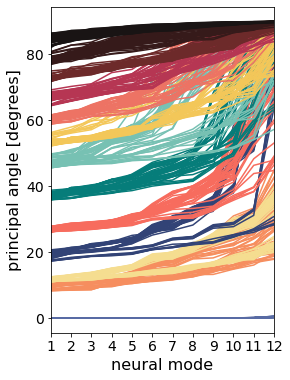

In [33]:
filename = 'principal_angles'
plt.figure(figsize=(4,6))

angles = np.zeros((n_p_offs, int(n_subspaces*(n_subspaces-1)/2), n_trials))

for p_off_i, p_off in enumerate(p_offs):
    count = 0
    for subspace_i in range(n_subspaces):
        for subspace_j in range(subspace_i+1, n_subspaces):
            for trial in range(n_trials):
                pc_i = pca_dict[p_off_i, subspace_i, trial].components_
                pc_j = pca_dict[p_off_i, subspace_j, trial].components_.T
            
                u, s, vh = np.linalg.svd(np.dot(pc_i, pc_j), full_matrices=True)
                angles[p_off_i, count, trial] = (np.arccos(np.clip(s,-1,1))*180/np.pi)[0]
            
                if subspace_i == 0 and subspace_j == 1 and trial == 0:
                    plt.plot(np.arange(1,13),np.arccos(np.clip(s,-1,1))*180/np.pi, colors[p_off_i%len(colors)], label=str(p_off))
                else:
                    plt.plot(np.arange(1,13),np.arccos(np.clip(s,-1,1))*180/np.pi, colors[p_off_i%len(colors)])

            count+=1
plt.xticks(np.arange(1,13), fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('neural mode', fontsize=16)
plt.ylabel('principal angle [degrees]', fontsize=16)
plt.xlim(1,12)

plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

In [34]:
angles.mean(axis=(1,2))

array([6.70699486e-07, 9.31636553e+00, 1.16103325e+01, 1.91826116e+01,
       2.67934571e+01, 3.71509840e+01, 4.73824494e+01, 5.34447568e+01,
       6.04457999e+01, 6.66473574e+01, 7.28698162e+01, 7.85616158e+01,
       8.45140101e+01])

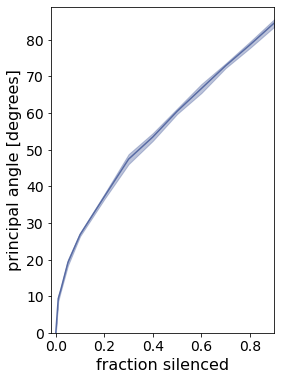

In [35]:
filename = 'average_principal_angles'
plt.figure(figsize=(4,6))
#plt.plot(p_offs, np.arccos(1-p_offs)*180/np.pi, color='grey', linestyle='--')
plt.plot(p_offs, angles.mean(axis=(1,2)), color=colors[0])
plt.fill_between(p_offs,
                 angles.mean(axis=(1,2)) - np.std(angles, axis=(1,2)),
                 angles.mean(axis=(1,2)) + np.std(angles, axis=(1,2)), 
                 color=colors[0], alpha=0.4)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('fraction silenced', fontsize=16)
plt.ylabel('principal angle [degrees]', fontsize=16)
#plt.axhline(0.7, color='grey', linestyle='--')
#plt.legend(fontsize=12)
plt.xlim(-0.02,0.9)
plt.ylim(0,89)

plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

### Single neurons

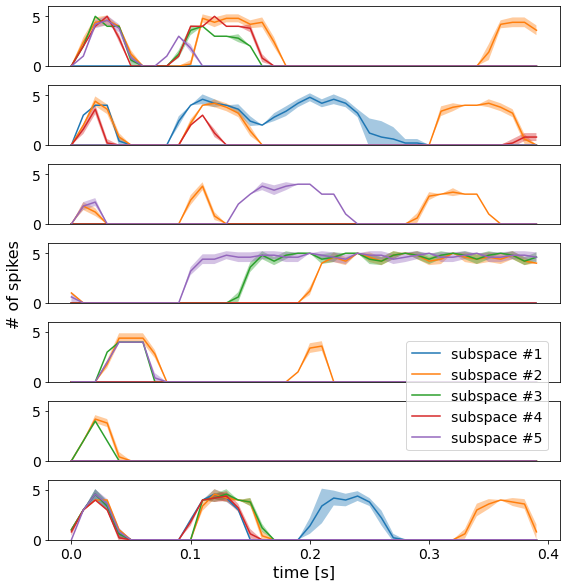

In [37]:
filename = 'single_neurons'
k = 8
n_exs = 10
t_start = 0

stride = 1
window = 10

# example neurons
neuron_exs = [12541, 400, 762, 8807, 102, 300, 11695]
n_exs = len(neuron_exs)

sing_neuron_colors = ['#586ba4', '#f76c5e']
fig, axs = plt.subplots(n_exs, figsize=(8,8))

for ex_i, ex in enumerate(neuron_exs):
    for i in range(n_subspaces):

        if ex_i == n_exs-1:
            axs[ex_i].plot(np.arange(t_start,n_bins), 
                           np.mean(spk_raster[k, i,:,ex,t_start:], axis=0), label='subspace #' + str(i+1))
        else:
            axs[ex_i].plot(np.arange(t_start,n_bins), 
                           np.mean(spk_raster[k, i,:,ex,t_start:], axis=0))
        axs[ex_i].fill_between(np.arange(t_start,n_bins),
                               np.mean(spk_raster[k, i,:,ex,t_start:], axis=0) - np.std(spk_raster[k, i,:,ex,t_start:], axis=0),
                               np.mean(spk_raster[k, i,:,ex,t_start:], axis=0) + np.std(spk_raster[k, i,:,ex,t_start:], axis=0), alpha=0.4)
        axs[ex_i].set_ylim(0,6)
        axs[ex_i].set_xticks([])
        axs[ex_i].set_yticks(np.arange(0,7,5))
        axs[ex_i].set_yticklabels(np.arange(0,7,5), fontsize=14)
        
axs[ex_i].set_xticks(np.arange(0,n_bins+1,10))
axs[ex_i].set_xticklabels(np.arange(0,(simtime+window)/1000,0.1).round(1), fontsize=14)
fig.supylabel('# of spikes', fontsize=16)
fig.tight_layout()
plt.xlabel('time [s]', fontsize=16)
plt.legend(fontsize=14, loc=[0.7,1.5])
plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')
plt.show()

In [38]:
active = np.zeros((n_p_offs, n_subspaces, n_trials, nPopE)) 
for p_off_i, p_off in enumerate(p_offs):
    for subspace in range(n_subspaces):
        for trial in range(n_trials):
            active[p_off_i,subspace,trial,:] = spk_raster[p_off_i, subspace, trial].sum(axis=1) > 0 

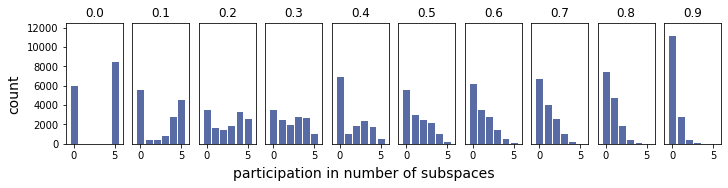

In [39]:
filename = 'mixed_selectivity'
fig, axs = plt.subplots(1,n_p_offs-3, figsize=(10,2.5), layout='constrained')
p_offs_sel = np.concatenate([[p_offs[0]], p_offs[4:]])
bins = np.arange(-0.35,6.5,1)
x = np.arange(0,6)
for i in range(n_p_offs-3):
    axs[i].set_title(p_offs_sel[i])
    axs[i].hist(active[np.where(p_offs == p_offs_sel[i])[0][0],:,0,:].sum(axis=0), width=0.85, color=colors[0], bins=bins)
    axs[i].set_ylim(0,12500)
    axs[i].set_xlim(-1,6)
    axs[i].set_yticks([])

axs[0].set_yticks(np.arange(0,14000,2000))
fig.supxlabel('participation in number of subspaces', fontsize=14)
fig.supylabel('count', fontsize=14)
#fig.tight_layout()
plt.savefig(figs_dir+filename+'.pdf', bbox_inches='tight')